We look more carefully into the bandwidth of the different detector.  
This study was raised by the fact that a bandwidth has to be chosen when simulating electronics. If we usually take 3.4-4.2 i.e. 800MHz bandwidth, depending on definition, it can be quite different.  
We want to see what is the effect of that.  

# Detector spectra

First let's take a look at the various spectra that we have in our arrays. (we only look at the C-band)

In [1]:
%matplotlib inline 

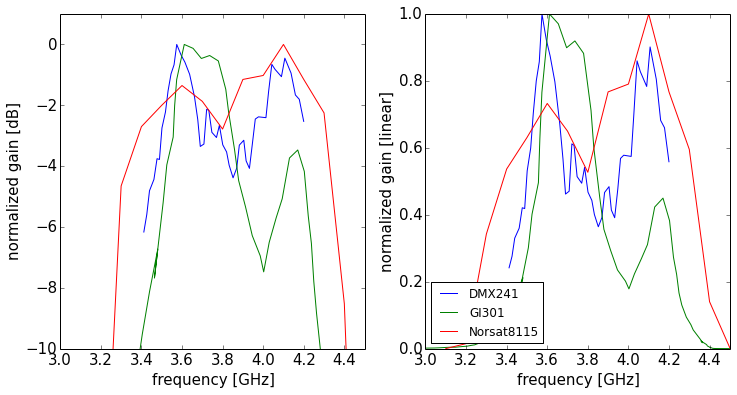

In [4]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/data/spectra/')
%run plotgain.py

If we compute an effective bandwidth as:
\begin{equation}
        \rm BW = \frac{1}{G_{max}} \int G(f) \cdot df
    \end{equation}

In [6]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/data/spectra/')
%run geteffbw.py

effective BW for  DMX241  =  0.476506348996
effective BW for  GI301  =  0.432403610591
effective BW for  Norsat8115  =  0.75010464778


So only the Norsat has a bandwidth close to 800MHz.  
The bandwidth can be important as the sensitivity goes with the inverse of the sqrt of the BW.
Note however that the product of the bw with the integration time tau is the one entering the formula. Since we did adjusted tau to fit the experimental distribution, we might have not been to wrong in total.

#Electronics simulation

## simple case

We have an electronics simulation code in order to test the signal filtering. 
To produce the noise waveform we start with a flat spectrum and a random phase of a defined bandwidth and with inverst fourier transform it.  
Here is an example of the produced noise waveform:
(f1 = 0 f2 = 2e9)

ratio =  1.42445684726


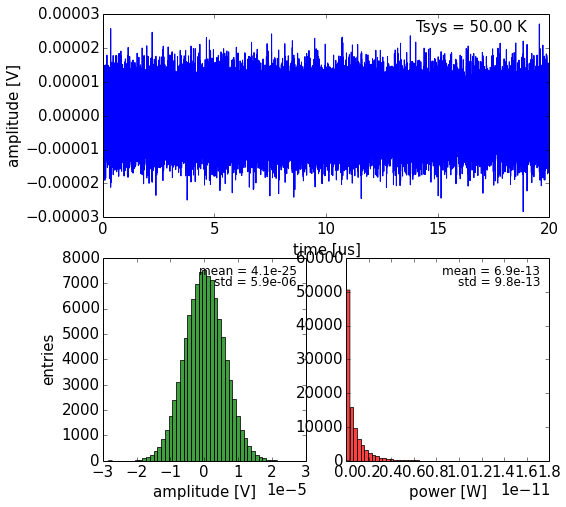

In [7]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run noise.py

We can verify that:
\begin{equation}
    \frac{\sigma_V^2}{50} = < P >  
\end{equation}

and that:
\begin{equation}
    \frac{\sigma_P}{<P>} = \sqrt{2}
\end{equation}

Just for a check, instead of taking frequency from zero, we take it from non zero and thus we reduce the bandwidth, we get very consistently sqrt(2)

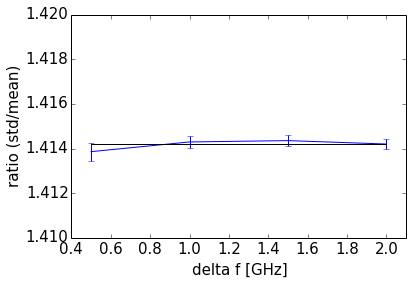

In [13]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run noiseinbw.py

Now if we filter we will get an additional factor in the ratio of the mean and the std.

There are different way to filter (like cut the fft, or window sliding), we want to look at the differences in the results we get.

First, here are the spectra for the voltage and the power:

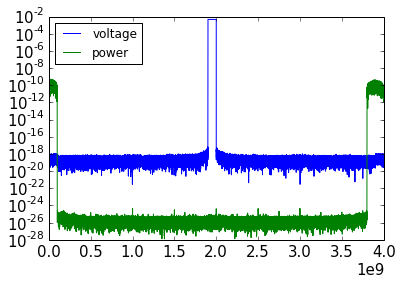

In [2]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run noisefiltered.py

**remark:be careful that since we do the square, the frequency is doubled on side, but if we keep a sampling of say 5GHz (meaning f_Nyq = 2.5GHz) the spectrum folds back at low frequency:**

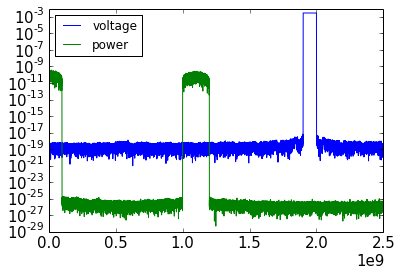

In [2]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run noisefiltered.py

**remark (ctd): This might be quite dangerous in fact (in my studies of course, in reality it is fine !)**
Next we will use 8GHz frequency sampling.

Ok now we can filter and check the formula:
\begin{equation}
    \frac{\sigma_P}{<P>} = \frac{\sqrt{2}}{\sqrt{\Delta f \cdot \tau}}
\end{equation}


In Tool of radio astronomy (Wilson,Rohlfs, Huttemeister), this formula is derived for $\Delta f$ i.e. the receiver's sampling band way smaller than the incoming BW.
First, we try by filtering by cutting the fft, taking $\tau$ as $1/f_{cut}$

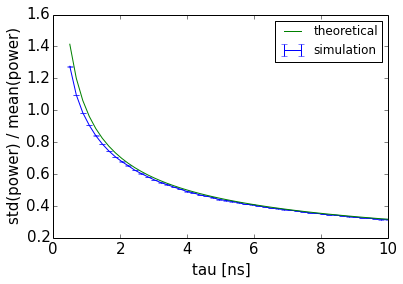

In [4]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run noisefiltered.py

They match very well for tau > 5ns below there are some slight discepancies.

If we vary the lower bound of the low frequency:

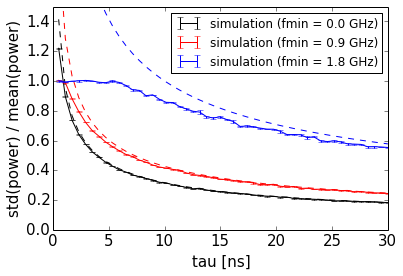

In [12]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run noisefiltered.py

this plot show:
- if you have a small bandwidth the theorical curve is matched for long tau (i.e. low frequencies), this make sense because for the small tau (high freq.) the filter keeps the total low frequency part (see spectra above). 
- The fact that it plateaus at one and not at sqrt(2) it is because the filter removes the high frequency part of the spectrum of the power.  

Now if we try a different filtering, for instance with a sliding window:

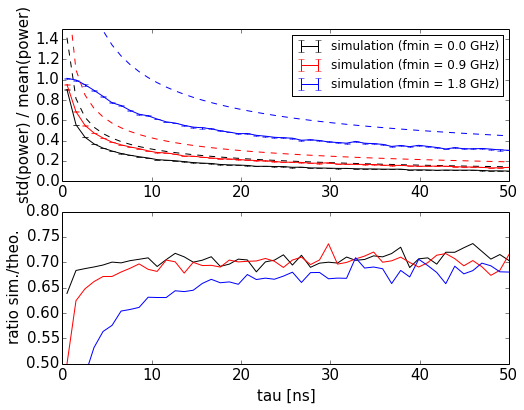

In [13]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run noisefiltered.py

The formula doesn't work anymore, there is another factor (looks like 0.7 or sqrt(2)/2 ?)

## our case

The difference with our case is that we don't filter strictly speaking, we use a power detector that puts the power in log and filters.  
The response was shown to be well reproduced by the convolution of the power in dB with an exponential decay function. Depending on the time decay, the filtering will be different. The question is what tau should we use, can we actually use the function above.
For that we will compare our simulations with the actual data.

### Implementation of the power detector and electronics chain.

The implementation is described in another note (electronics simulation). 
the steps are summed up here:
- log10 the power
- convolute with an exponential
- rescale the signal accordind the power detector linear-log relation/ the adaptation board.
- filter at 20MHz (front end antialiasing filter)
- sample in time and amplitude

Here is an example of the result:

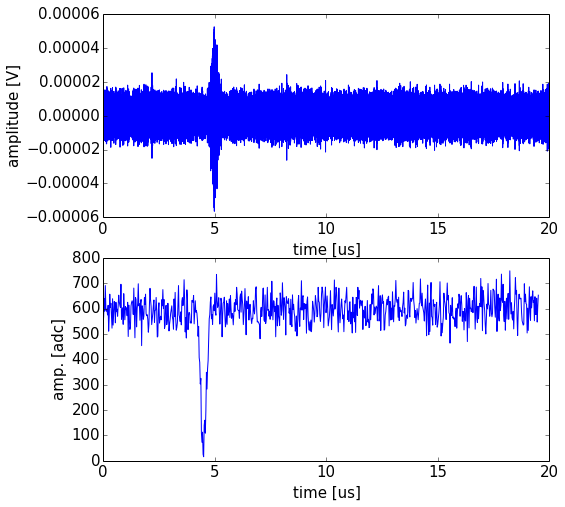

In [3]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run det.py

Now what we want to know is how the bandwidth and the chose tau affects the std of a noise waveform for instance. Here is the distribution for a tau of 5ns, and a nominal bandwidth (0.95 - 1.75GHz)

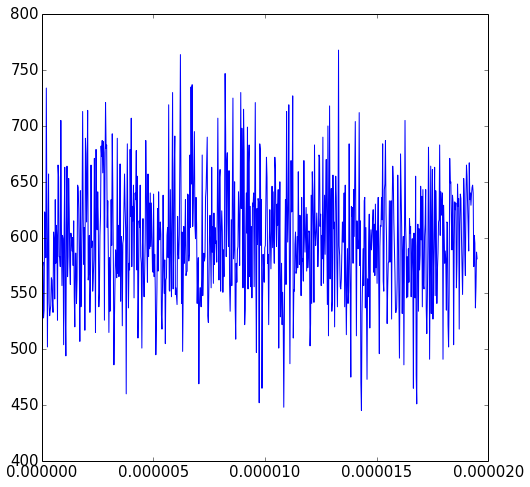

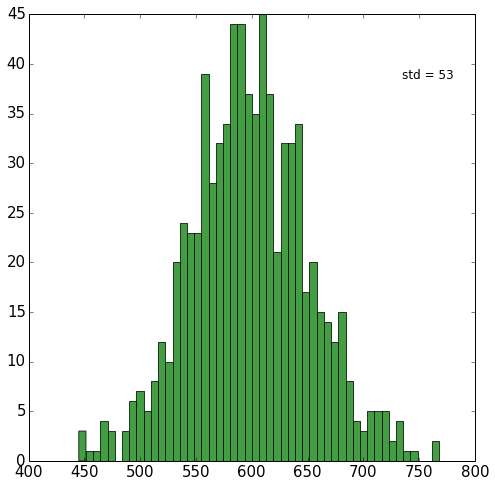

In [7]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run noisedist.py

Then if we vary tau:

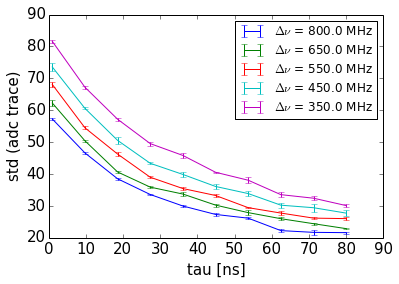

In [14]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run noisedist.py

Now let's have a look at this ratio for a realistic spectrum.

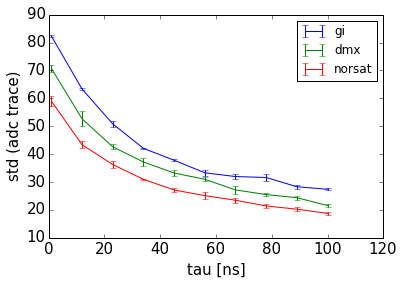

In [3]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run testspec.py

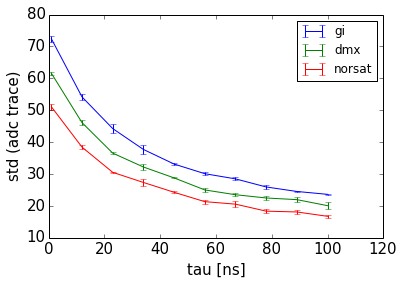

In [2]:
import os
os.chdir('/Users/romain/work/Auger/EASIER/LPSC/filter/test/')
%run testspec.py

Here I find a problem because the observed rms is either ~50 for the DMX without capa, or ~25-30 in the case with capacitor. This would give a to large tau compared to what I found in my thesis.  
Several possible bugs:
    - the bandwidth is wrong (especially the norsat is in fact the gain and not the aeff)
    - I did something wrong in my thesis
    - there is something else 

I check these possibilities in the following chapter:

## problem with electronics simulation

### bandwidth

The bandwidth we need to account for is the in fact the effective area and not the gain.  
The power received by the power detector is:

\begin{equation}
    \rm
    P (\nu) = F(\nu)* A_{eff}(\nu) * G_{LNB} (\nu)
\end{equation}

with $\rm F(\nu) = cst$ the 